
### Binary Image Classifier to determine if the image of someone's face has a filter or not. Use case instructions.

 - Was trained on 8 different instagram filters and 6 different camera filters.




- Input size: 3x128x128, 128x128 resolution RGB image

- 0: No Filter

- 1: Filter


For more information look at the _______, where it was trained

## Imports

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random

import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image

import os
from PIL import Image, ImageEnhance, ImageFilter, ImageOps

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Define Model Architecture

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=9):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(6)
        
        self.fc = nn.Linear(6 * 32 * 32, num_classes)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(x)
        x = self.bn1(self.dropout1(x))
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


model = CNNModel(num_classes=9).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

## Load the trained checkpoint

In [4]:
checkpoint_path = 'checkpoints_camera/model1_tests_1.pth'

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# Testing accuracy on labeled images

I've provided a sample test_dataset of images of myself. The folder should have two subfolders, filtered and unfiltered, both just containing images.

Binary classification accuracy on the test set: 58.82%
Incorrect predictions: 


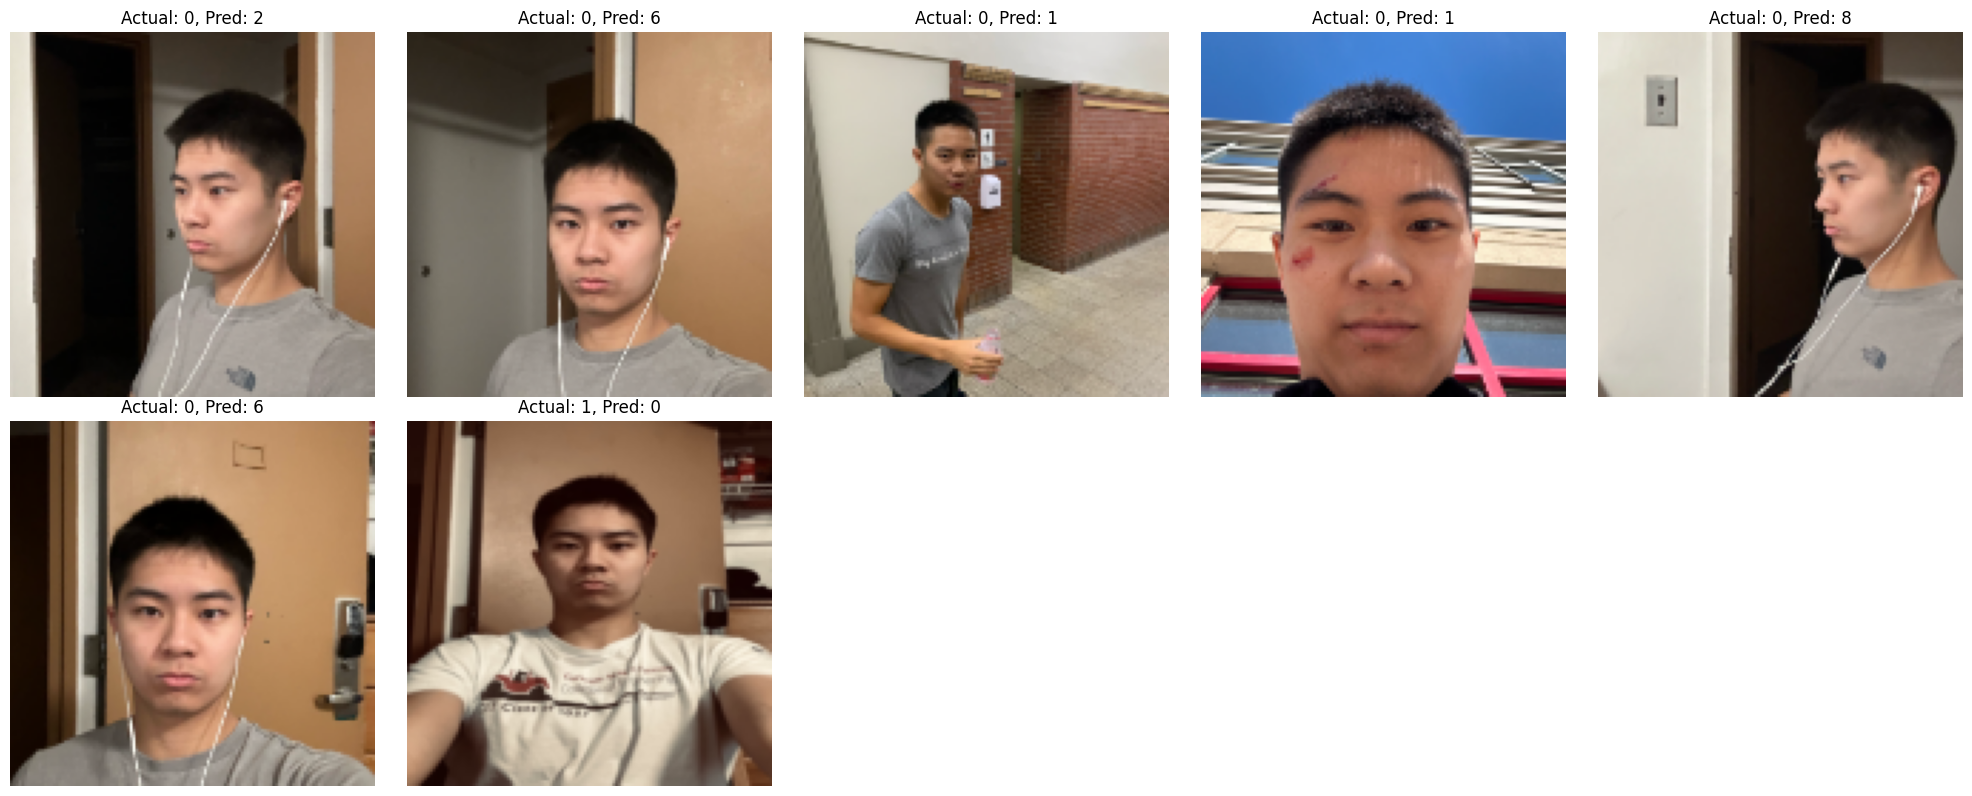

In [5]:
class FilteredUnfilteredDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.base_dir = base_dir
        self.transform = transform
        self.samples = []

        unfiltered_dir = os.path.join(base_dir, 'unfiltered')
        self.samples += [(os.path.join(unfiltered_dir, f), 0) for f in os.listdir(unfiltered_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        filtered_dir = os.path.join(base_dir, 'filtered')
        self.samples += [(os.path.join(filtered_dir, f), 1) for f in os.listdir(filtered_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')  # Use PIL to open and ensure 3 channels
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# replace test_daset with your own dataset in this format: 

# dataset
#   --- filtered
#          --- bunch of images
#   --- unfiltered
#          --- bunch of images


data_dir = 'test_dataset'
dataset = FilteredUnfilteredDataset(base_dir=data_dir, transform=transform)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

def evaluate_and_display_incorrect_predictions(model, data_loader, device, transform, images_per_row=5):
    model.eval()
    correct = 0
    total = 0
    incorrect_images = []
    incorrect_preds = []
    incorrect_actuals = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            binary_predicted = (predicted != 0).long()
            binary_labels = (labels != 0).long()
            correct += (binary_predicted == binary_labels).sum().item()
            total += labels.size(0)
            mask = binary_predicted != binary_labels
            incorrect_images.extend(images[mask].cpu())
            incorrect_preds.extend(predicted[mask].cpu().numpy())
            incorrect_actuals.extend(labels[mask].cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Binary classification accuracy on the test set: {accuracy:.2f}%')

    print("Incorrect predictions: ")

    num_incorrect = len(incorrect_images)
    if num_incorrect > 0:
        rows = (num_incorrect + images_per_row - 1) // images_per_row
        plt.figure(figsize=(20, rows * 4))
        for idx, image in enumerate(incorrect_images):
            plt.subplot(rows, images_per_row, idx + 1)
            img = transforms.ToPILImage()(image)
            plt.imshow(img)
            plt.title(f"Actual: {incorrect_actuals[idx]}, Pred: {incorrect_preds[idx]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

evaluate_and_display_incorrect_predictions(model, test_loader, device, transform)


# Showing output on unlabeled images

Provide a the path to a folder of just images.

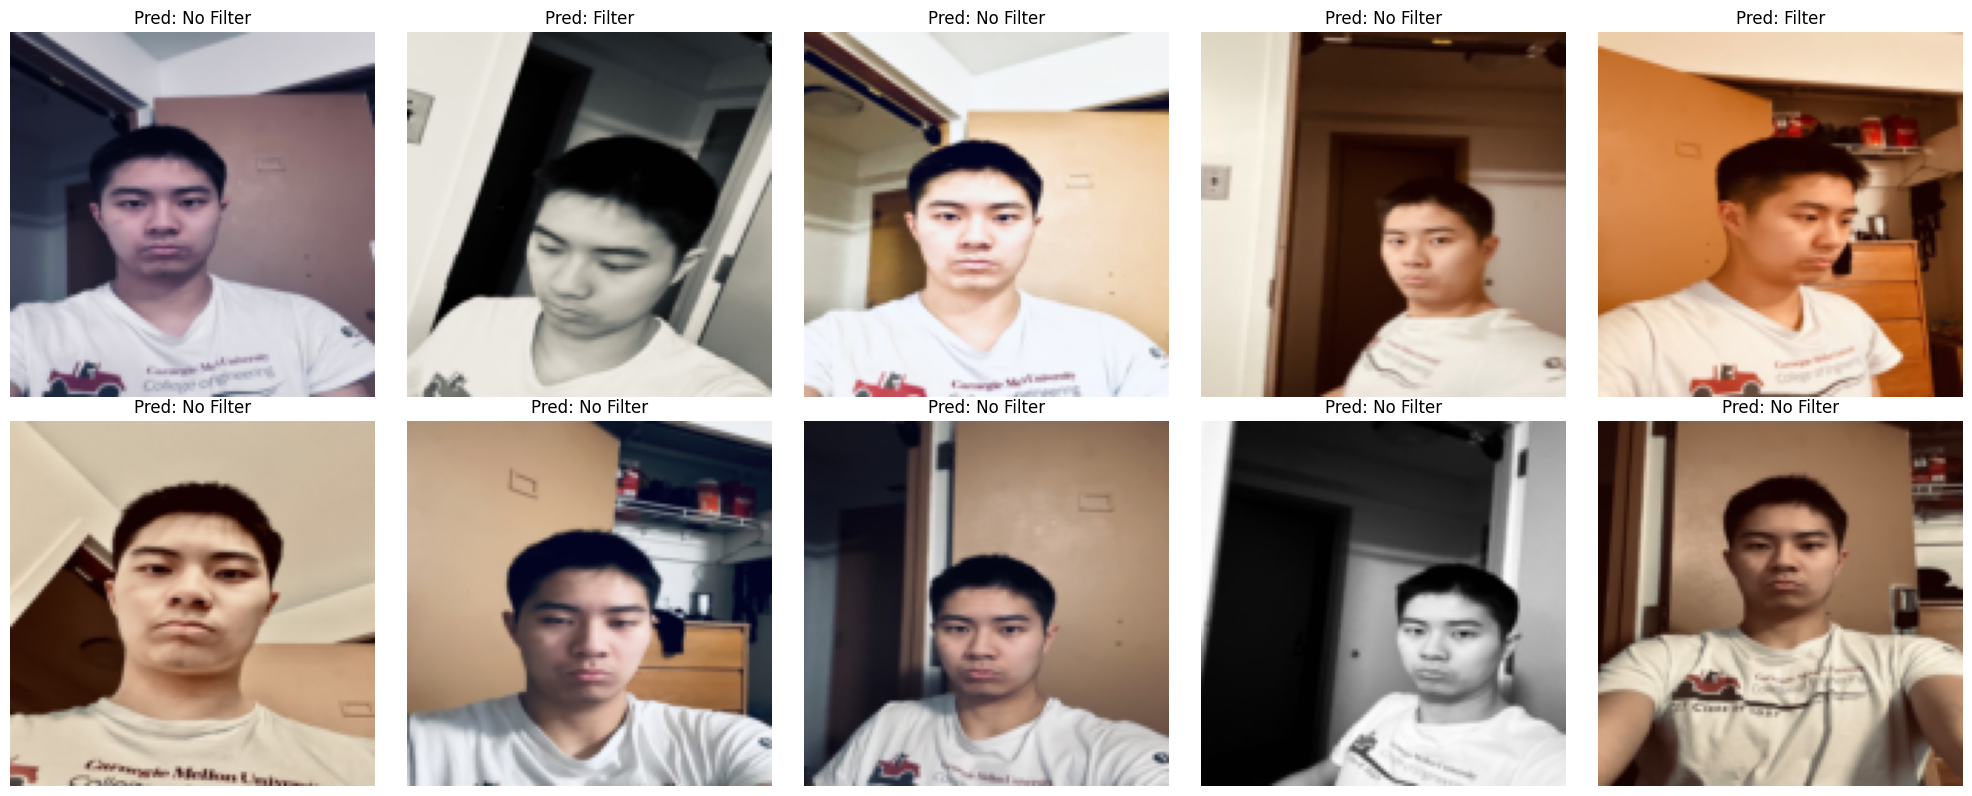

In [203]:
class SingleImageDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.folder_path, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

def predict_and_display_in_columns(folder_path, model, device, transform, images_per_row=5):
    dataset = SingleImageDataset(folder_path, transform)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

    model.eval()
    total_images = len(dataset)
    rows = (total_images + images_per_row - 1) // images_per_row

    plt.figure(figsize=(20, rows * 4))
    with torch.no_grad():
        for idx, images in enumerate(data_loader):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            binary_preds = (preds != 0).long()

            img = transforms.ToPILImage()(images.cpu().squeeze())
            plt.subplot(rows, images_per_row, idx + 1)
            plt.imshow(img)
            plt.title(f"Pred: {'Filter' if binary_preds.item() else 'No Filter'}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

image_folder = 'test_dataset/filtered'
predict_and_display_in_columns(image_folder, model, device, transform)
